In [3]:
import os
import pandas as pd
import numpy as np
import sys
import torch
from torchvision import transforms
from torch.utils.data import DataLoader as TorchDataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.notebook import tqdm

# --- (Recomendado) Recarga automática de módulos ---
%load_ext autoreload
%autoreload 2

# --- Añadir la carpeta raíz al path para encontrar la carpeta 'src' ---
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Añadido al path: {project_root}")

# --- IMPORTAMOS NUESTRA ARQUITECTURA ---
from src.architecture import Dataset, collate_fn, Model

# --- Configuración del Dispositivo ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {DEVICE}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Usando dispositivo: cuda


In [4]:
# --- Rutas de Datos ---
RAW_DATA_PATH = "../data/raw/color"
PROCESSED_DATA_PATH = "../data/processed/"

# --- Carga del DataFrame y filtrado para el Test set ---
df_full_splitted = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'dataframe_splitted.csv'))
df_test = df_full_splitted[df_full_splitted['split'] == 'test'].copy()
df_test['image_path'] = df_test['relative_path'].apply(lambda rel_path: os.path.join(RAW_DATA_PATH, rel_path))
print(f"Cargado el conjunto de test con {len(df_test)} muestras.")

# --- Mapeo de Clases y Transformación ---
all_classes = sorted(df_full_splitted['class'].unique())
label_map = {label: i for i, label in enumerate(all_classes)}
NUM_CLASSES = len(all_classes)
data_transform = transforms.Compose([transforms.Resize((224, 224))])

# --- Crear Dataset y DataLoader de Test ---
test_dataset = Dataset(df_test['image_path'].values, df_test['class'].values, label_map, trans=data_transform)
test_dataloader = TorchDataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


Cargado el conjunto de test con 10861 muestras.


In [5]:
def evaluate_model(model, dataloader, device):
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluando en Test Set"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

In [6]:
# --- Modelos a Evaluar ---
models_to_evaluate = {
    # Estrategia 1
    "S1 - Baseline":          {'path': 'Strat1_Baseline_best.pth', 'pretrained': False},
    "S1 - Transfer Learning": {'path': 'Strat1_TL_best.pth', 'pretrained': True},
    "S1 - Fine-Tuning":       {'path': 'Strat1_FT_best.pth', 'pretrained': True},
    # Estrategia 2
    "S2 - Baseline":          {'path': 'Strat2_Baseline_best.pth', 'pretrained': False},
    "S2 - Transfer Learning": {'path': 'Strat2_TL_best.pth', 'pretrained': True},
    "S2 - Fine-Tuning":       {'path': 'Strat2_FT_best.pth', 'pretrained': True}
}

evaluation_results = {}

for name, info in models_to_evaluate.items():
    print(f"\n--- Evaluando modelo: {name} ---")
    model = Model(num_classes=NUM_CLASSES, pretrained=info['pretrained'])
    try:
        model.load_state_dict(torch.load(info['path'], map_location=DEVICE))
        true_labels, predictions = evaluate_model(model, test_dataloader, DEVICE)
        evaluation_results[name] = {'true_labels': true_labels, 'predictions': predictions}
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo del modelo '{info['path']}'.")
        # Añadimos un resultado vacío para no romper las visualizaciones
        evaluation_results[name] = None


--- Evaluando modelo: S1 - Baseline ---


Evaluando en Test Set:   0%|          | 0/170 [00:00<?, ?it/s]


--- Evaluando modelo: S1 - Transfer Learning ---


Evaluando en Test Set:   0%|          | 0/170 [00:00<?, ?it/s]


--- Evaluando modelo: S1 - Fine-Tuning ---


Evaluando en Test Set:   0%|          | 0/170 [00:00<?, ?it/s]


--- Evaluando modelo: S2 - Baseline ---


Evaluando en Test Set:   0%|          | 0/170 [00:00<?, ?it/s]


--- Evaluando modelo: S2 - Transfer Learning ---


Evaluando en Test Set:   0%|          | 0/170 [00:00<?, ?it/s]


--- Evaluando modelo: S2 - Fine-Tuning ---


Evaluando en Test Set:   0%|          | 0/170 [00:00<?, ?it/s]


Resultados Finales para: S1 - Baseline
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.943     0.913     0.927       126
                                 Apple___Black_rot      0.947     1.000     0.973       124
                          Apple___Cedar_apple_rust      0.929     0.945     0.937        55
                                   Apple___healthy      0.938     0.967     0.952       329
                               Blueberry___healthy      0.983     0.990     0.987       300
          Cherry_(including_sour)___Powdery_mildew      1.000     0.933     0.966       210
                 Cherry_(including_sour)___healthy      0.924     0.994     0.958       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      1.000     0.515     0.679       103
                       Corn_(maize)___Common_rust_      0.996     1.000     0.998       239
               Corn_(maize)___Northern_

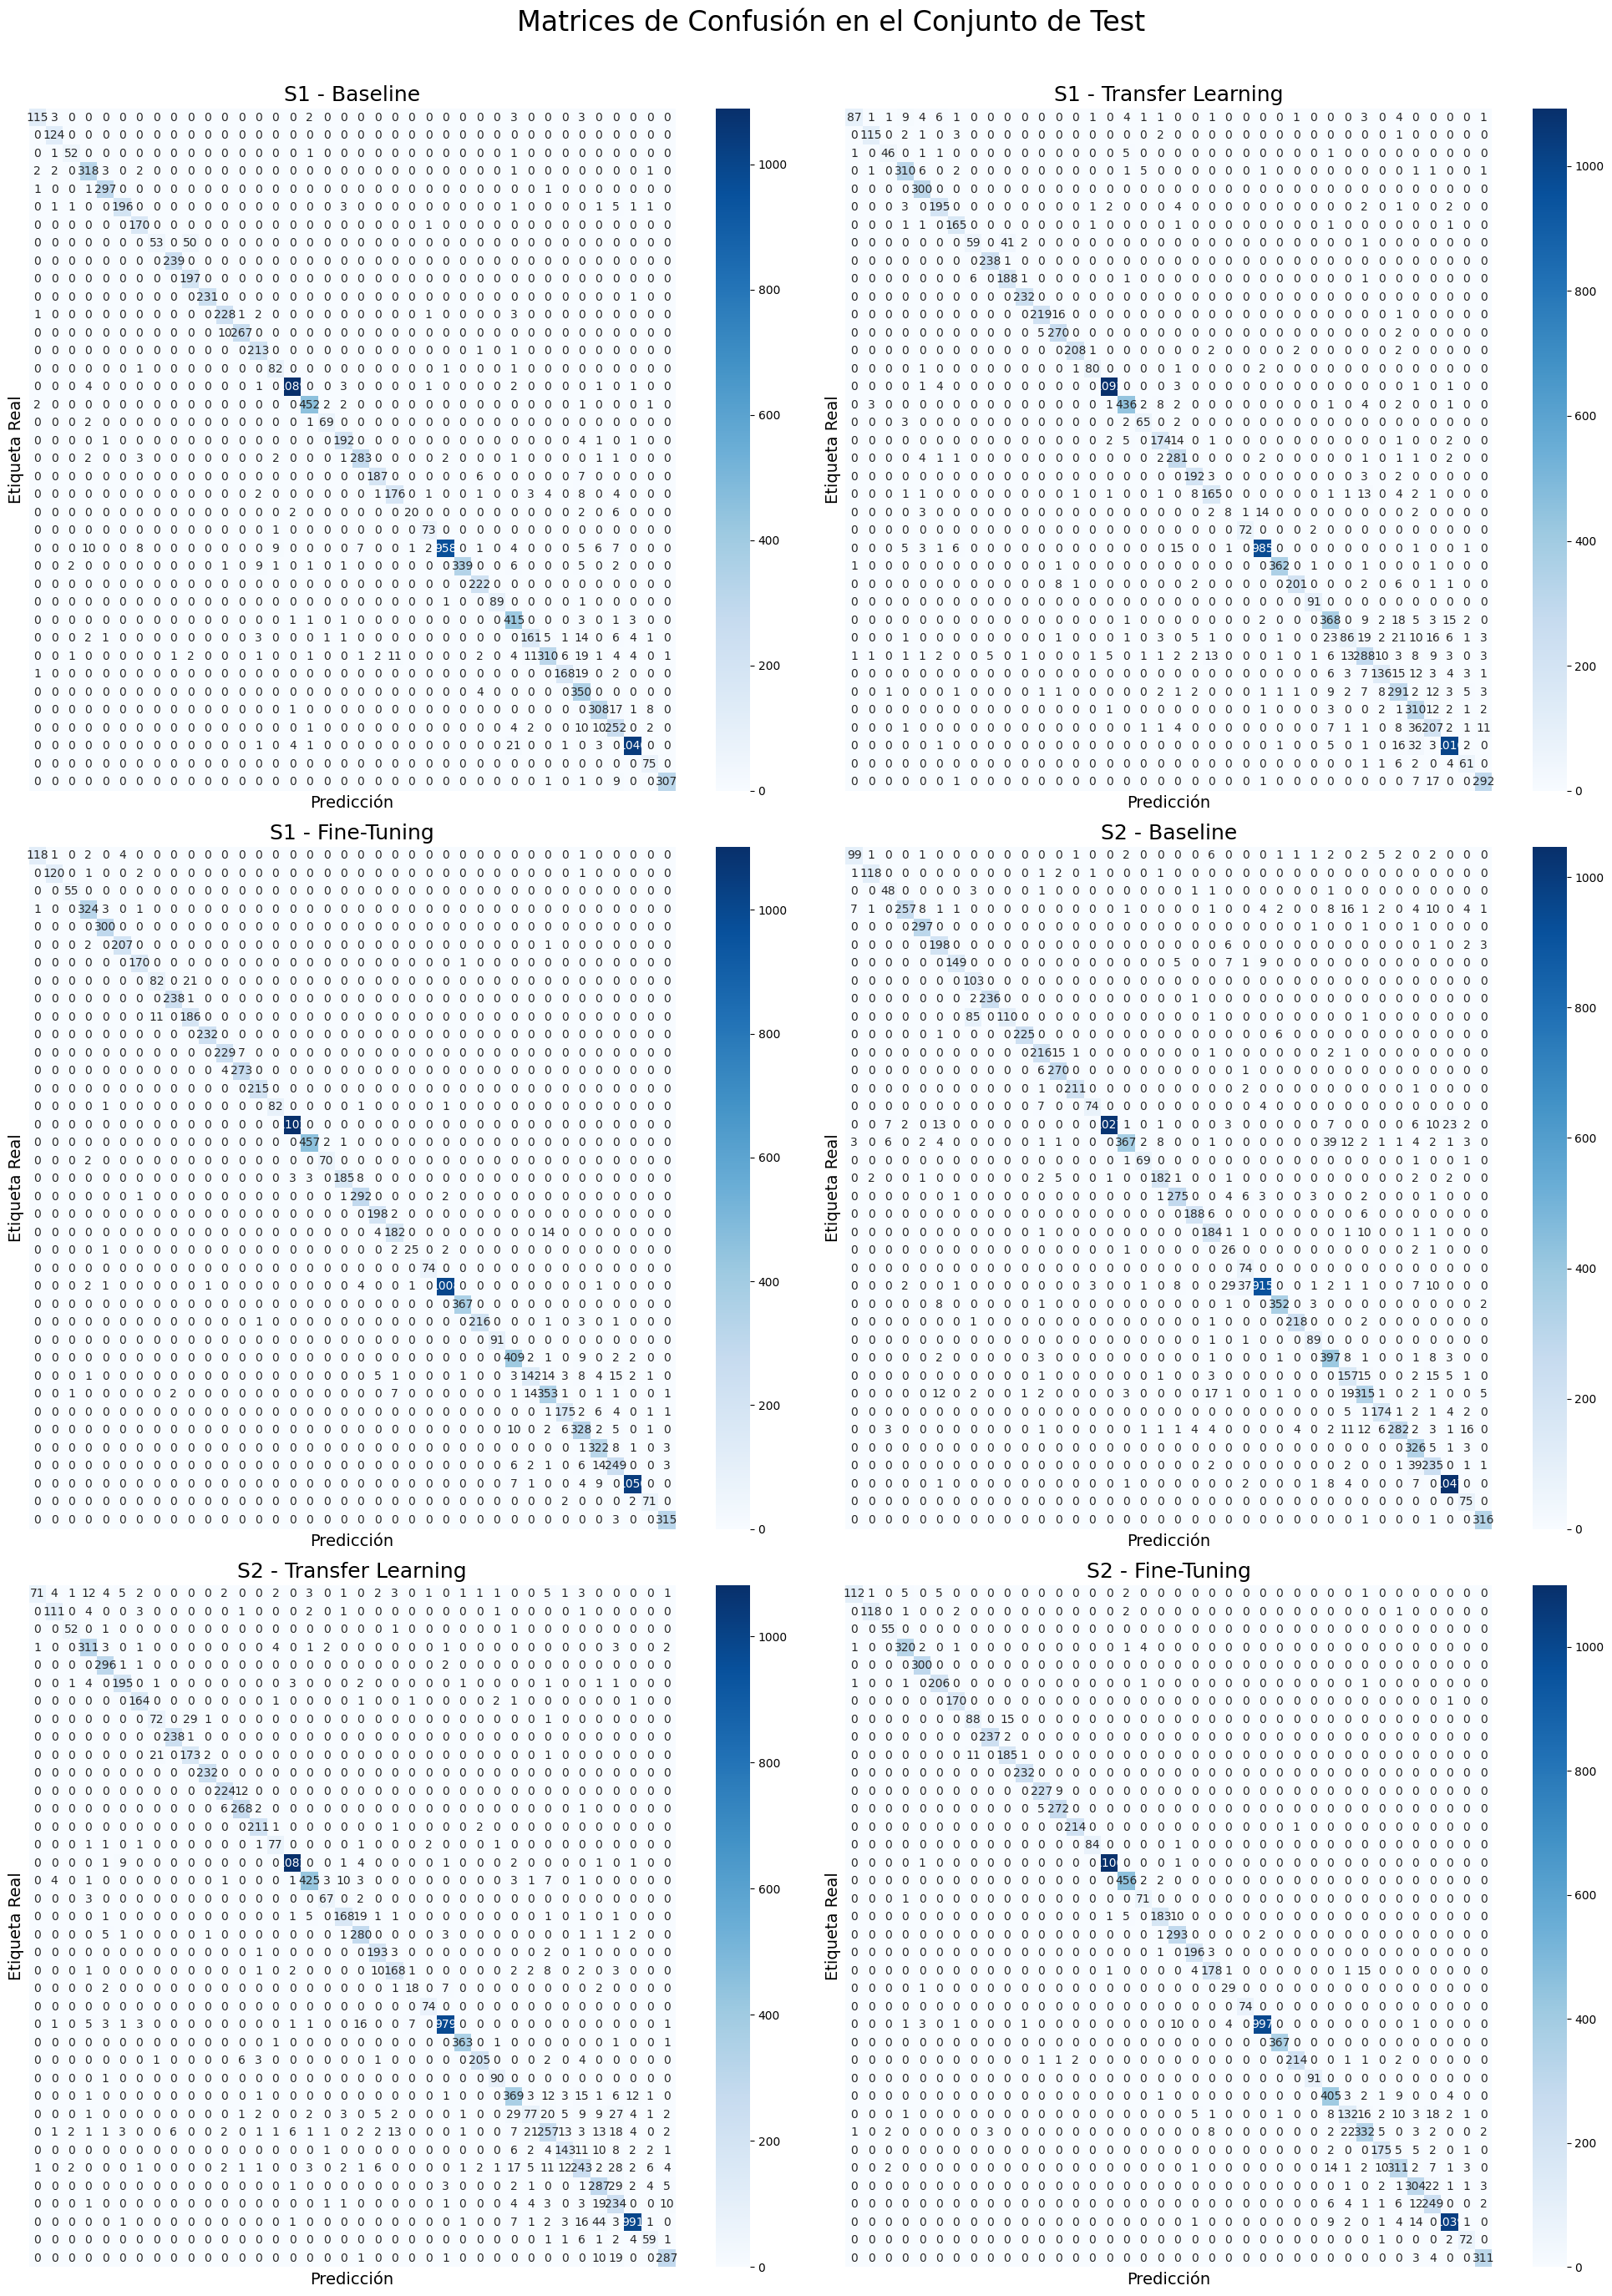

C:\Users\adria\AppData\Local\Temp\ipykernel_6548\2476284524.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\adria\AppData\Local\Temp\ipykernel_6548\2476284524.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\adria\AppData\Local\Temp\ipykernel_6548\2476284524.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


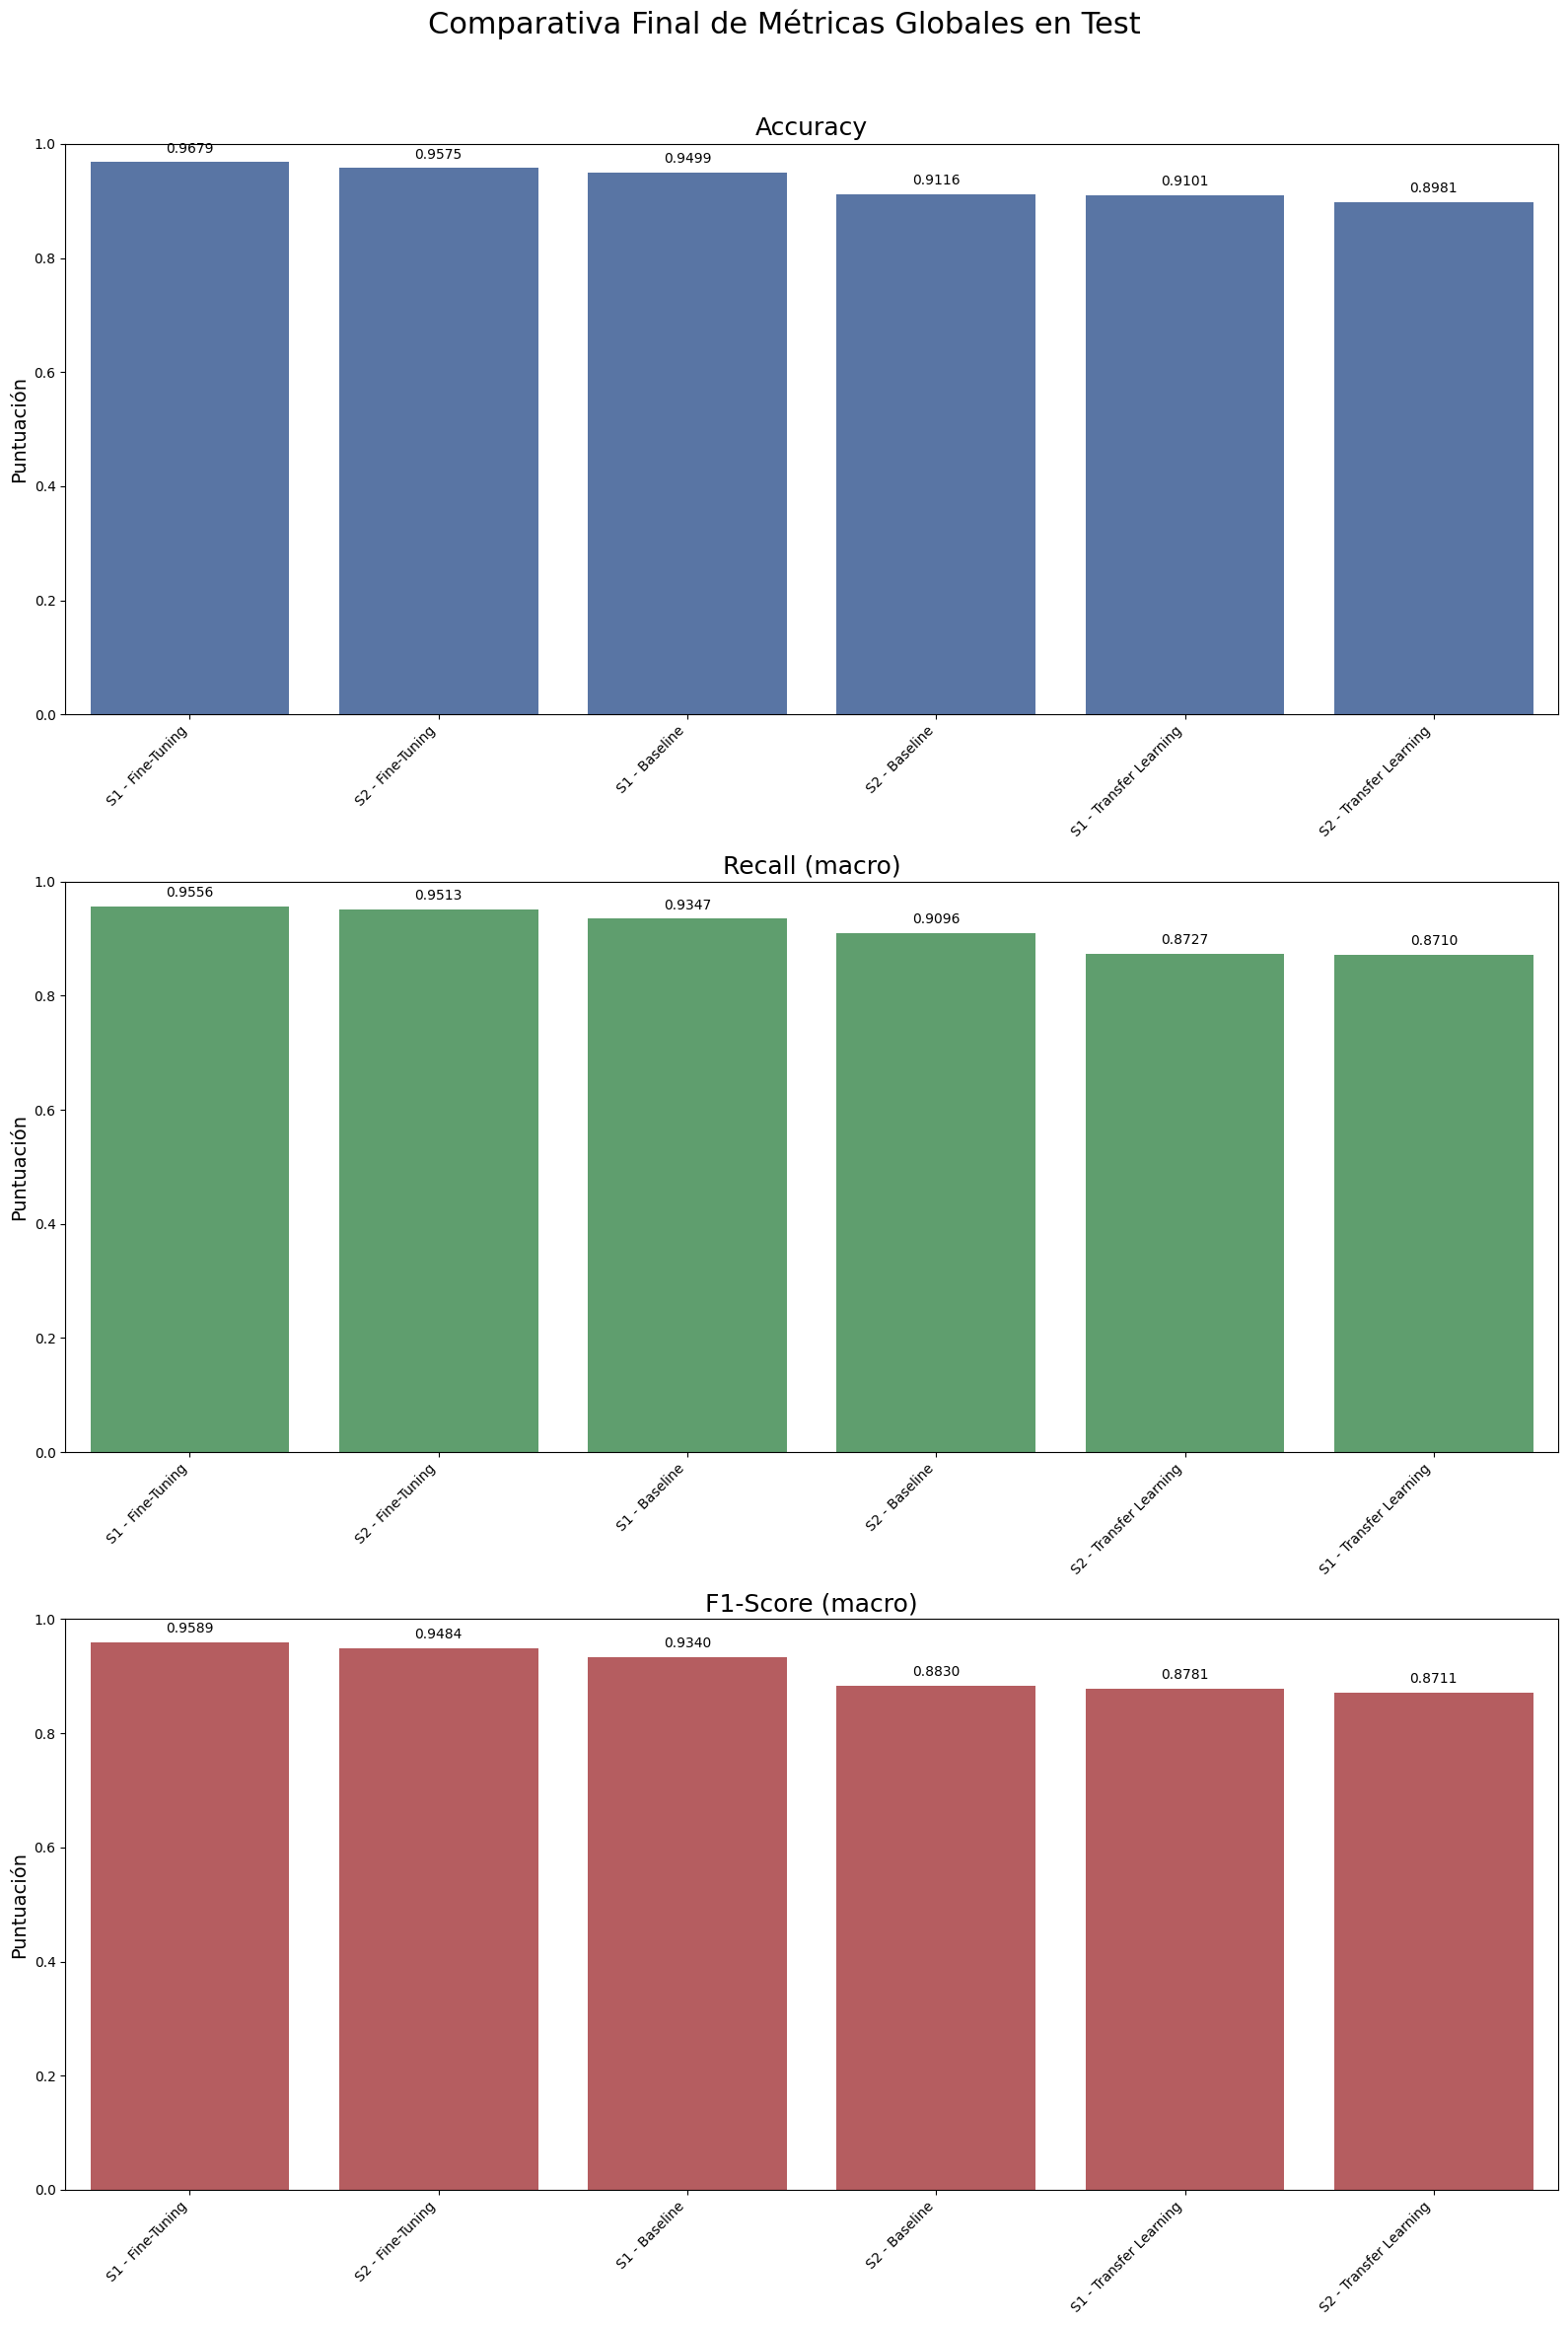

In [11]:
# Filtramos los resultados que no se pudieron cargar
valid_results = {k: v for k, v in evaluation_results.items() if v is not None}

if valid_results:
    # --- 1. Reportes de Clasificación Detallados ---
    class_names = [name for name, i in sorted(label_map.items(), key=lambda item: item[1])]
    for name, results in valid_results.items():
        print("\n" + "="*60)
        print(f"Resultados Finales para: {name}")
        print("="*60)
        print(classification_report(results['true_labels'], results['predictions'], target_names=class_names, digits=3))

    # --- 2. Matrices de Confusión ---
    fig, axes = plt.subplots(3, 2, figsize=(20, 28))
    fig.suptitle("Matrices de Confusión en el Conjunto de Test", fontsize=24)
    axes = axes.flatten()
    for i, (name, results) in enumerate(valid_results.items()):
        ax = axes[i]
        cm = confusion_matrix(results['true_labels'], results['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=False, yticklabels=False)
        ax.set_title(name, fontsize=18)
        ax.set_xlabel("Predicción", fontsize=14)
        ax.set_ylabel("Etiqueta Real", fontsize=14)
    for j in range(len(valid_results), len(axes)): axes[j].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # --- 3. Gráficos de Barras Comparativos (VERSIÓN CORREGIDA) ---
    
    # 3.1. Extraer todas las métricas resumen en un DataFrame
    summary_data = []
    for name, results in valid_results.items():
        report = classification_report(
            results['true_labels'], 
            results['predictions'], 
            output_dict=True
        )
        summary_data.append({
            'Modelo': name,
            'Accuracy': report['accuracy'],
            'Recall (macro)': report['macro avg']['recall'],
            'F1-Score (macro)': report['macro avg']['f1-score']
        })
    summary_df = pd.DataFrame(summary_data)

    # 3.2. Crear una figura con 3 filas y 1 columna
    fig, axes = plt.subplots(3, 1, figsize=(16, 24))
    fig.suptitle('Comparativa Final de Métricas Globales en Test', fontsize=22)

    metrics_to_plot = ['Accuracy', 'Recall (macro)', 'F1-Score (macro)']
    colors = ['#4c72b0', '#55a868', '#c44e52']

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        plot_df = summary_df.sort_values(metric, ascending=False)
        
        sns.barplot(x='Modelo', y=metric, data=plot_df, ax=ax, color=colors[i])
        
        ax.set_title(metric, fontsize=18)
        ax.set_xlabel('')
        ax.set_ylabel('Puntuación', fontsize=14)
        ax.set_ylim(0, 1.0)
        
        # --- LÍNEA CORREGIDA ---
        # Se aplica la rotación y alineación a las etiquetas directamente, no a los ticks.
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        # Añadir el valor exacto sobre cada barra
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.4f}", 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', 
                        xytext=(0, 10), textcoords='offset points')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("No se generaron resultados de evaluación. Verifica que los modelos se hayan cargado correctamente.")

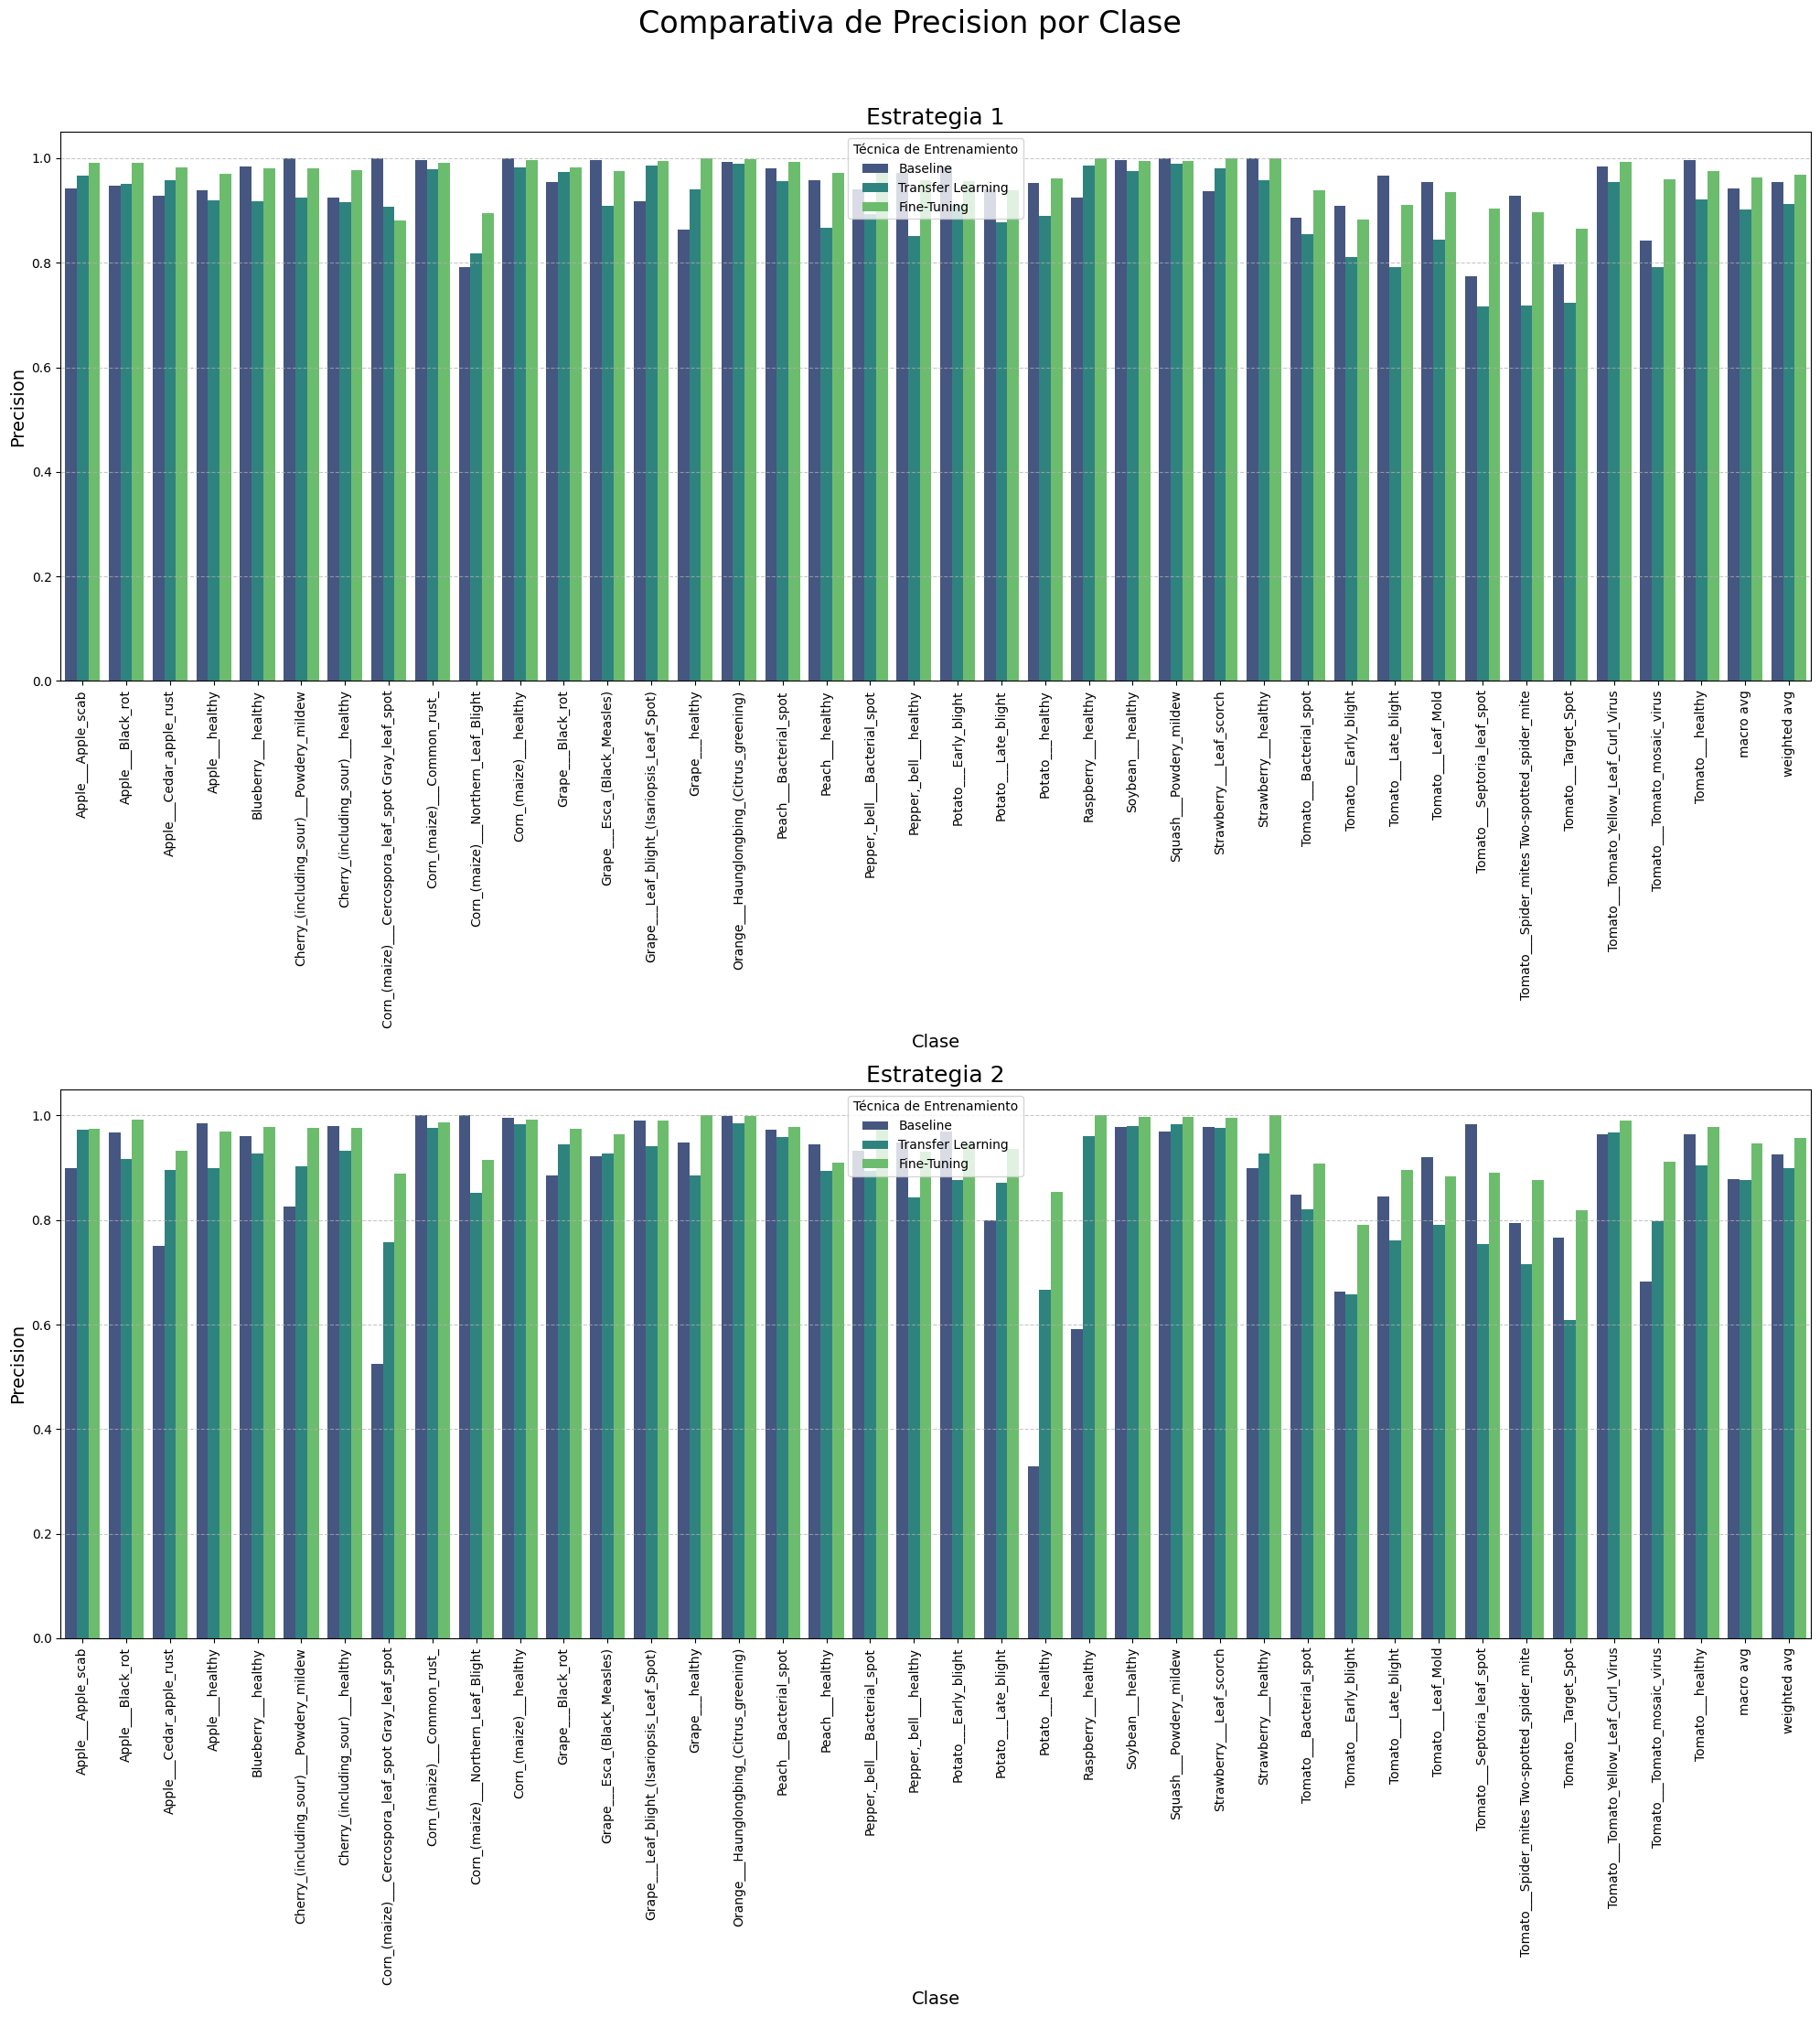

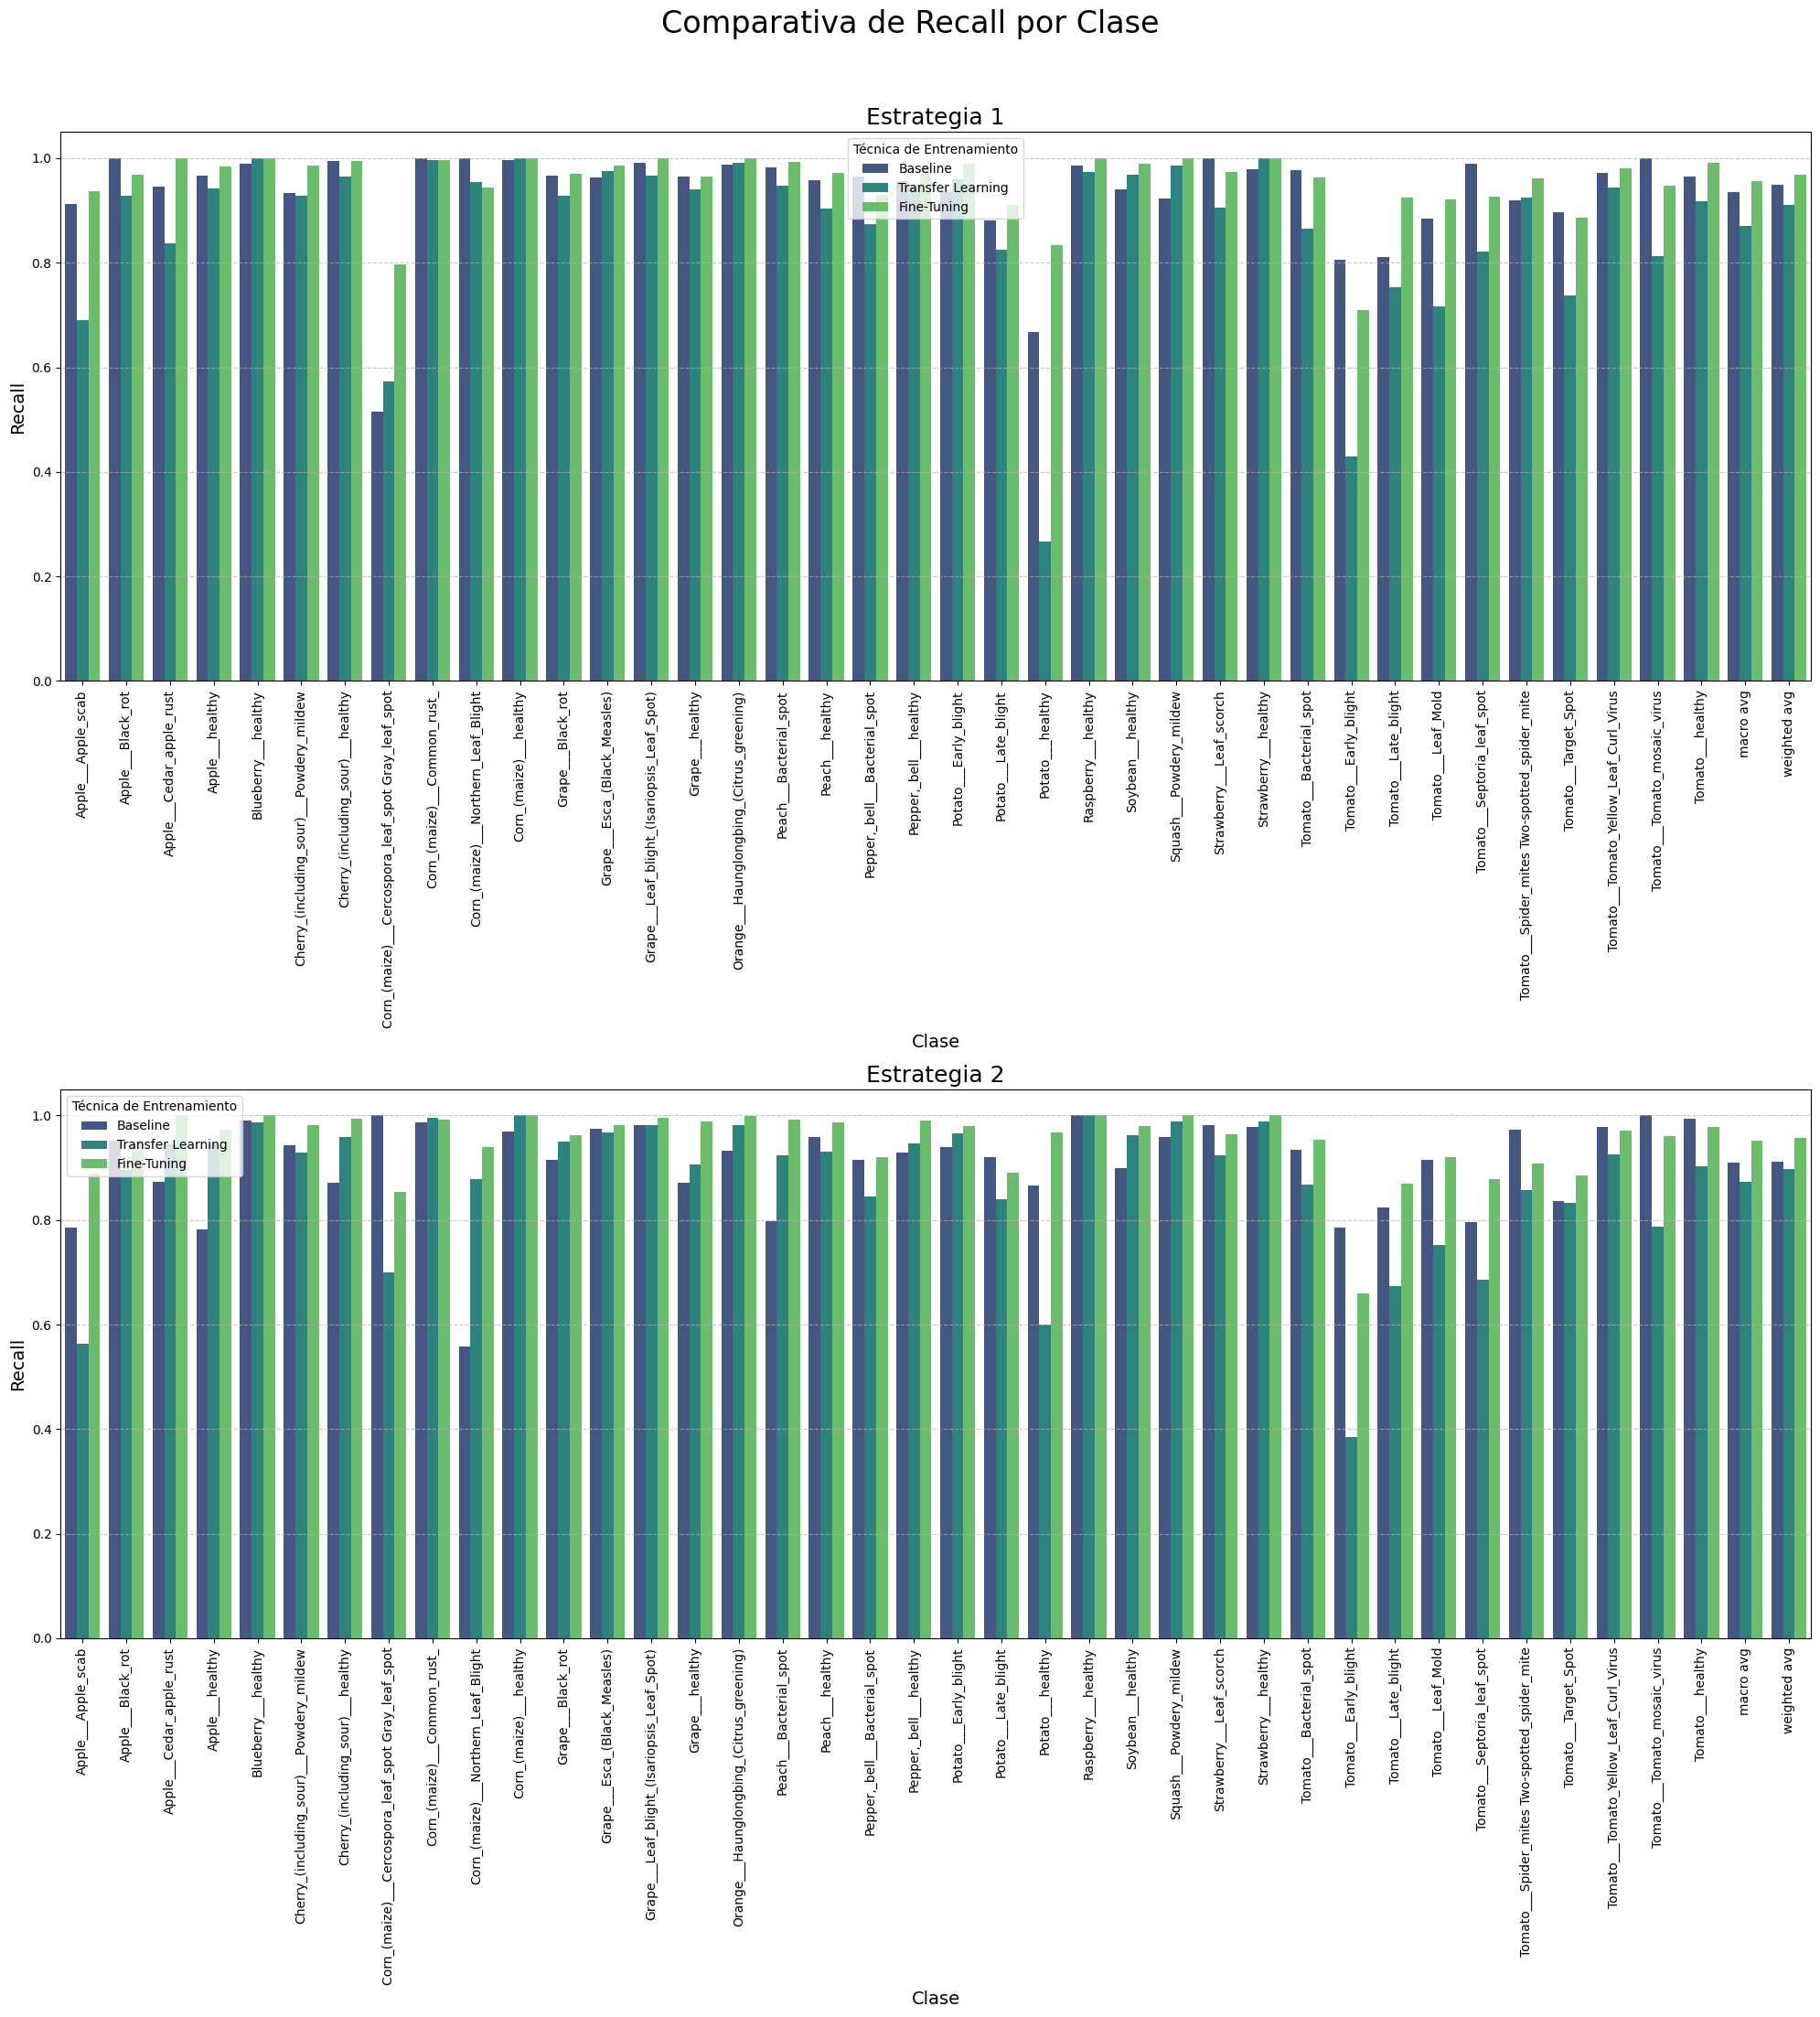

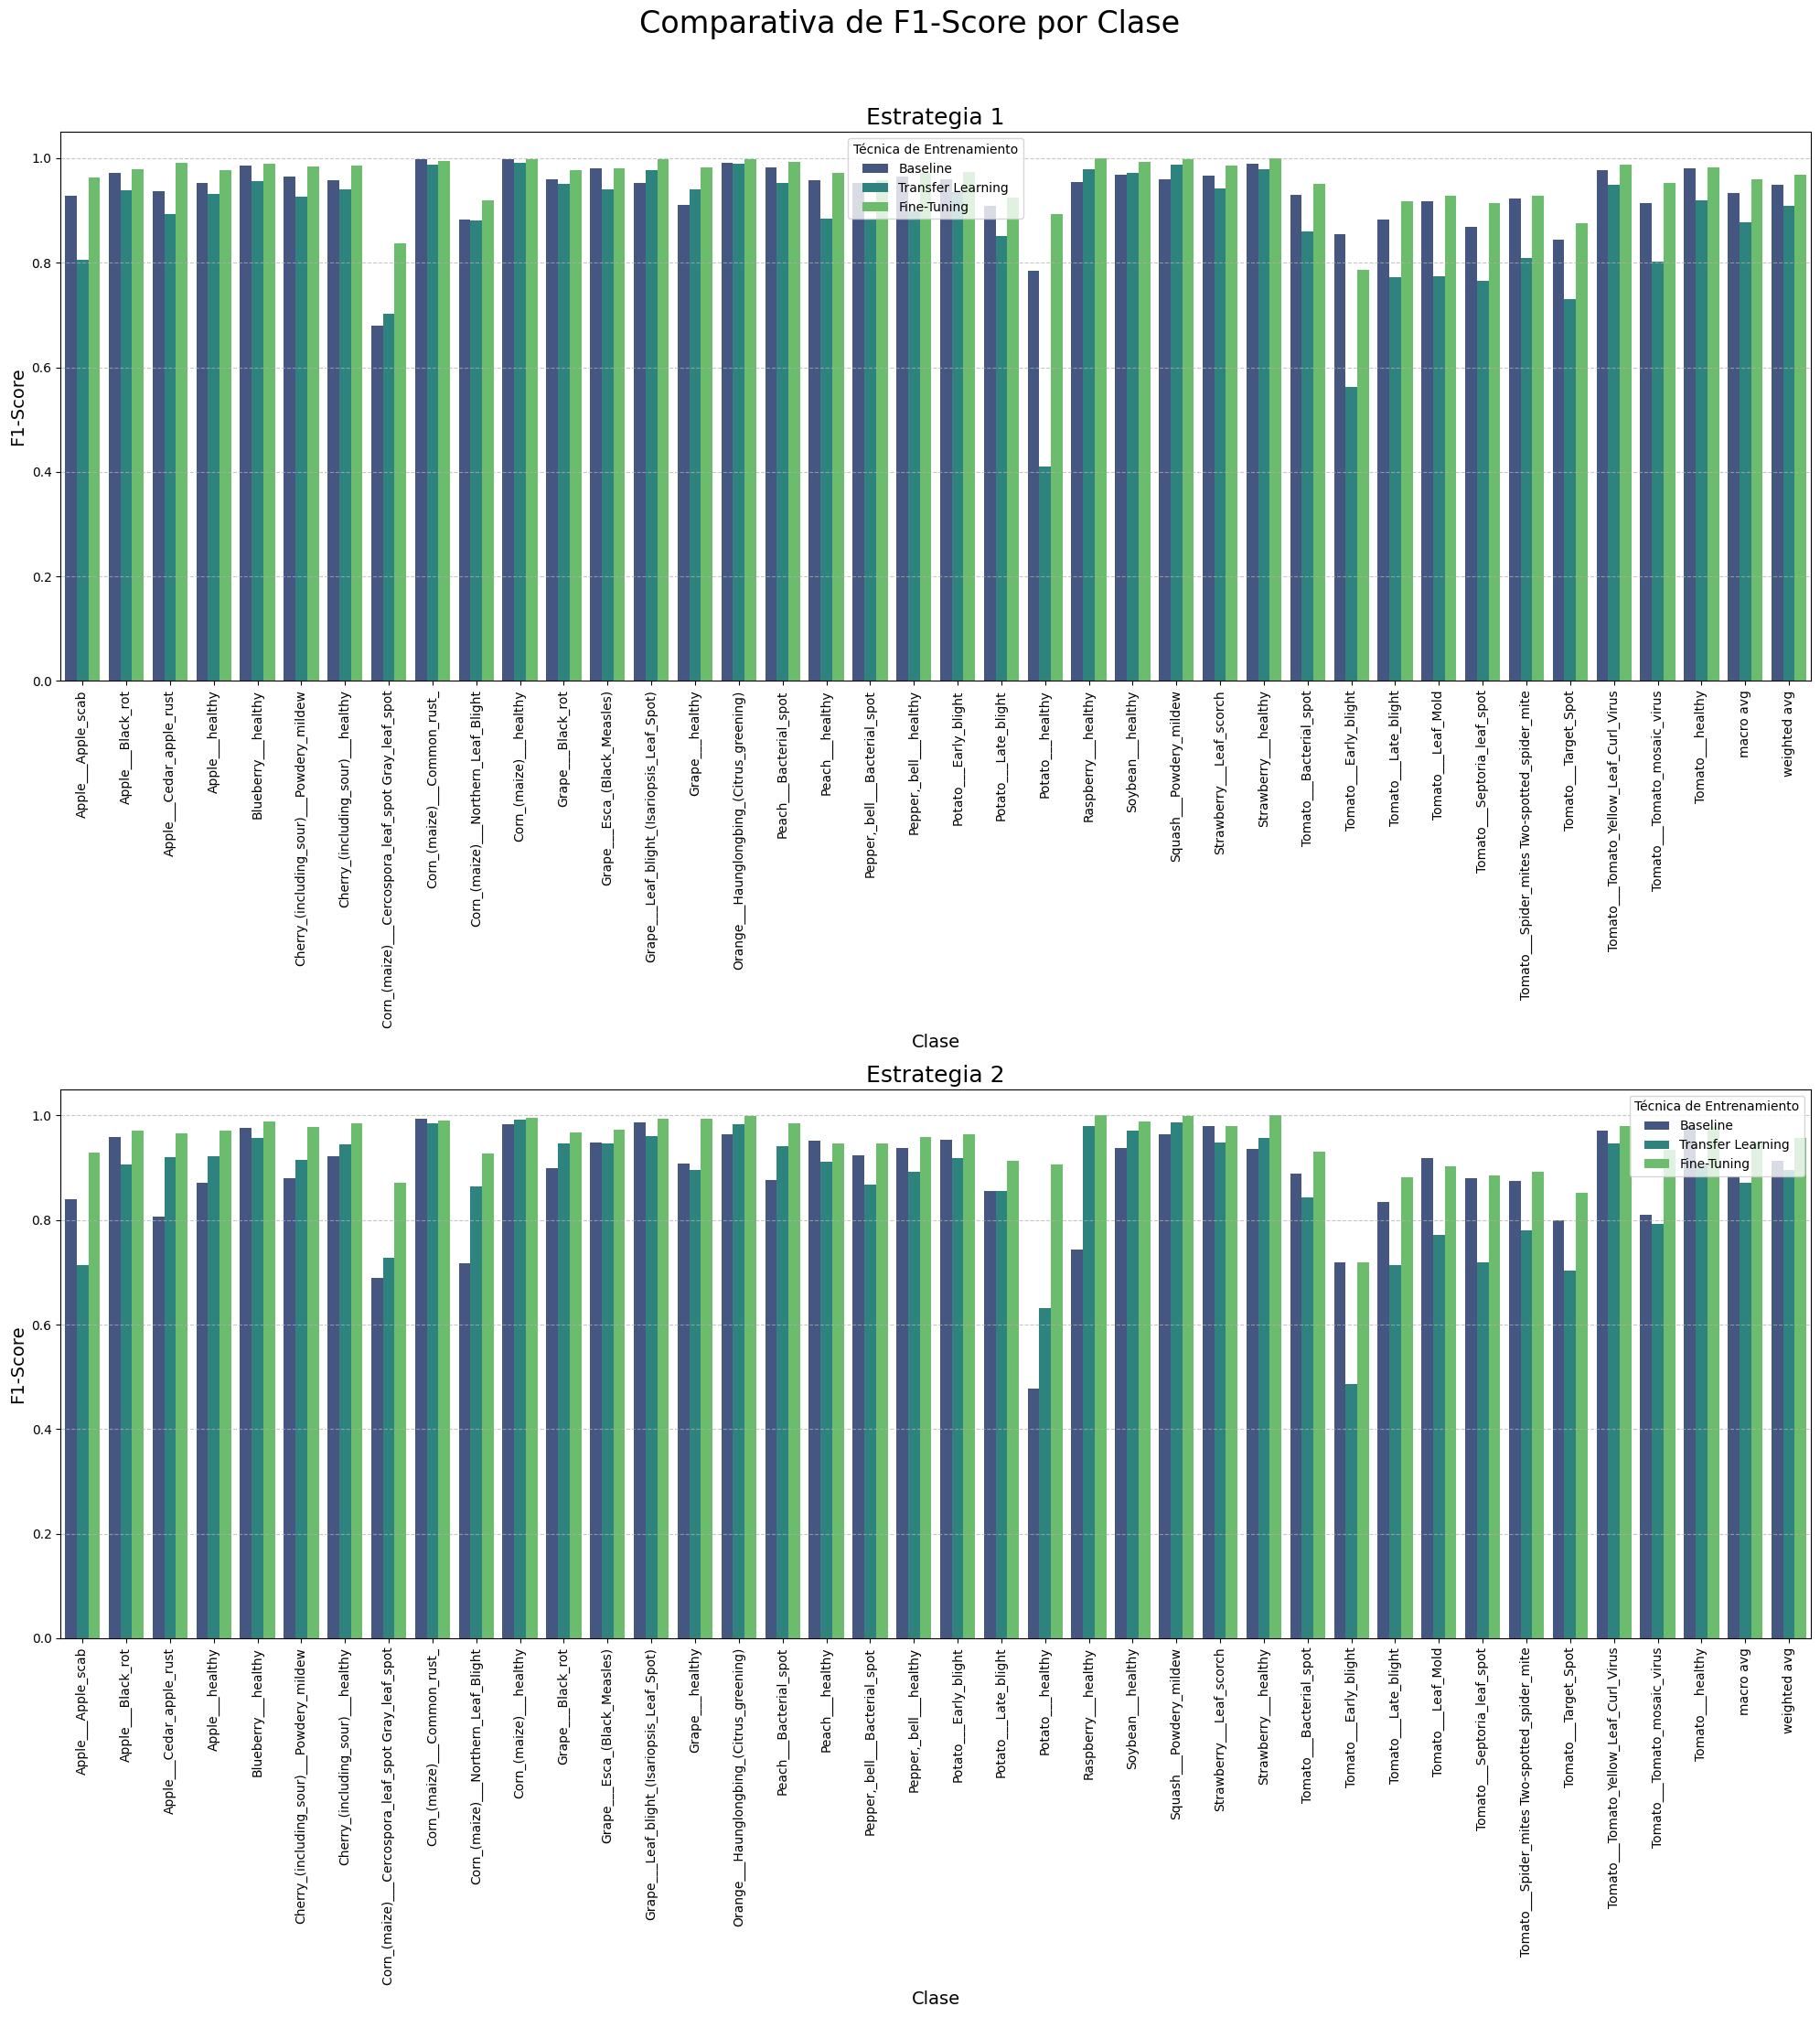

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Extraer y Estructurar los Datos de Métricas ---
metrics_data = []
if 'valid_results' in locals() and valid_results:
    # Obtenemos la lista de nombres de clases para el mapeo
    class_names = [name for name, i in sorted(label_map.items(), key=lambda item: item[1])]
    
    for model_name, results in valid_results.items():
        # Generamos el reporte de clasificación pero como un diccionario
        report = classification_report(
            results['true_labels'], 
            results['predictions'], 
            target_names=class_names,
            output_dict=True
        )
        
        # Iteramos sobre cada clase en el reporte
        for class_name, metrics in report.items():
            # Nos aseguramos de que sea una clase y no una métrica resumen (como 'accuracy')
            if isinstance(metrics, dict):
                metrics_data.append({
                    'Modelo': model_name,
                    'Estrategia': 'Estrategia 1' if 'S1' in model_name else 'Estrategia 2',
                    'Técnica': model_name.split(' - ')[1], # Extrae 'Baseline', 'Transfer Learning', etc.
                    'Clase': class_name,
                    'Precision': metrics.get('precision', 0),
                    'Recall': metrics.get('recall', 0),
                    'F1-Score': metrics.get('f1-score', 0)
                })

    # Convertimos la lista de datos en un DataFrame de Pandas
    metrics_df = pd.DataFrame(metrics_data)
else:
    print("No se encontraron resultados de evaluación ('valid_results'). Ejecuta las celdas anteriores.")
    metrics_df = pd.DataFrame() # Creamos un DF vacío para evitar errores

# --- 2. Función para Graficar las Métricas por Estrategia ---
def plot_metrics_by_class(df, metric_name):
    """
    Crea una figura con dos subplots (uno por estrategia) para una métrica específica.
    """
    if df.empty:
        print(f"No hay datos para graficar la métrica: {metric_name}")
        return
        
    # Usamos subplots para separar por estrategia
    fig, axes = plt.subplots(2, 1, figsize=(20, 22), sharey=True)
    fig.suptitle(f'Comparativa de {metric_name} por Clase', fontsize=24, y=1.0)

    for i, estrategia in enumerate(['Estrategia 1', 'Estrategia 2']):
        ax = axes[i]
        strategy_df = df[df['Estrategia'] == estrategia]
        
        sns.barplot(data=strategy_df, x='Clase', y=metric_name, hue='Técnica', ax=ax, palette='viridis')
        
        ax.set_title(f'{estrategia}', fontsize=18)
        ax.set_ylabel(metric_name, fontsize=14)
        ax.set_xlabel('Clase', fontsize=14)
        ax.tick_params(axis='x', rotation=90, labelsize=10)
        ax.legend(title='Técnica de Entrenamiento')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# --- 3. Generar las 3 Figuras Solicitadas ---
if not metrics_df.empty:
    plot_metrics_by_class(metrics_df, 'Precision')
    plot_metrics_by_class(metrics_df, 'Recall')
    plot_metrics_by_class(metrics_df, 'F1-Score')

## Conclusiones
Según las métricas de precisión (accuracy), reacll (sensibilidad) y F1 la mejor estrategía fue el aumento de datos no balanceado, que solamente  aumenta las clases pero no recorta la cantidad en clases dominantes. Además, el modelo de fine-tunning donde se parte de un modelo con un learning rate mayor y luego se pasa a uno menor de este hiperparametro, facilita aumenta la precisión de las predicciones en todas las clases.